<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY-9163-ML-cyber/blob/main/Lab/MLSec_Lab2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Adversarial Attacks on Deep Neural Networks

## Overview
In this lab, you will investigate adversarial perturbation attacks on Deep Neural Networks using the MNIST digits dataset as a benchmark. You will then evaluate adversarial retraining as a defense against adversarial perturbations.

## Dataset
The fashion_MNIST dataset is a commonly used “toy” benchmarks for machine learning. It contains 28X28 grayscale images with a label from 10 classes, along with the associated labels. The dataset is available as part of the tensorflow package, which you will be using extensively in this lab.

## What You Have to Do
The sample Google Colab notebook
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb#scrollTo=h3IKyzTCDNGo
that implements a 2-layer DNN for MNIST digit classification. The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations. You will implement your attacks and defenses on this baseline DNN.

* **FGSM based untargeted attacks**: Your first goal is to implement FGSM based untargeted attacks using images from the test set on the baseline DNN. That is, your goal is to adversarially perturb each image in the test set using the following values of parameter $\epsilon$ = {1, 5, 10, 20, 30, 40, 50}/255 assuming pixel values are normalized in the range [0,1]. Report the success rate of your attack, i.e., the fraction of test images that were
correctly classified by the baseline DNN that are mis-classified after adversarial perturbation, as a function of $\epsilon$.

* **FGSM based targeted attacks**: Next, you will repeat Step 1 above, except this time perform targeted attacks where digit i is classified as (i+1)%10 on the baseline DNN. (Here, i refers to the true ground-truth label of the test images, and you can assume that the attacker has access to these labels.) As before, use the following values of the parameter $\epsilon$ = {1, 5, 10, 20, 30, 40, 50}/255. Report the attack’s success rate as a function of parameter $\epsilon$, where success rate is defined as the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbations with label (i+1)%10.

* **Adversarial Retraining against Untargeted FGSM Attacks**: For this step, you can assume $\epsilon$ = 10/255 throughout. To defend against adversarial perturbations, the defender adversarially perturbs each image in her training set using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their correct labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the adversarially retrained DNN.

  *  Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs.
  * Is the adversarially retrained DNN robust against adversarial perturbations?
Implement FGSM based untargeted attacks using images from the clean test set on the adversarially retrained DNN. Report the success rate of your attack.

* **Challenge**: Finally, you will all compete in an adversarial attack challenge. You are free to use any adversarial attack detection procedure to implement untargeted attacks on a 2-layer baseline DNN. You are welcome to implement IFGSM or PGD attacks for example. For this problem you will simply submit your adversarially perturbed test images from the Fashion_MNIST dataset. The constraint is that the Root Mean Square Error averaged over all the images in the the original and modified datasets should be less than 5/255. assuming images are normalized to lie between [0,1].

## What to Submit
* Colab Notebook and its pdf format.
* Please submit 1 Colab Notebook and 1 PDF file without zipping.
* For the Challenge, please submit a file containing your adversarially modified test images

## Import packages and process data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from numpy import newaxis

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape)
print(x_test.shape)
print(type(x_train))

(60000, 28, 28)
(10000, 28, 28)
<class 'numpy.ndarray'>


We will visualize the data

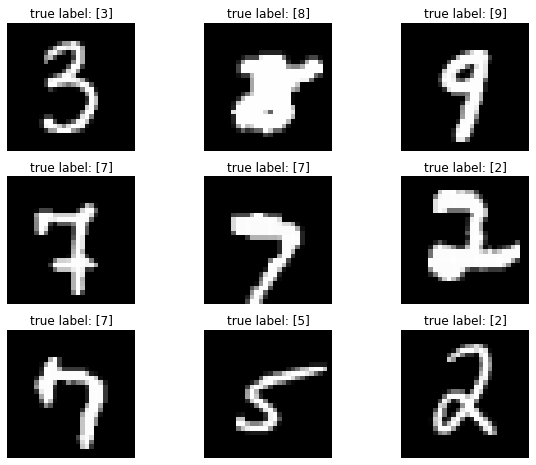

In [4]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_train.shape[0], size=1)
  img, label = (x_train[index], y_train[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Baseline DNN model
The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations.

In [5]:
DNN = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)                                 
])

In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [7]:
DNN.compile(optimizer='adam', loss=loss_fn,metrics=['accuracy'])

In [8]:
DNN.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2184 - accuracy: 0.9361
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0870 - accuracy: 0.9732
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0592 - accuracy: 0.9812
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0399 - accuracy: 0.9872
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0312 - accuracy: 0.9898


In [9]:
res = DNN.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0711 - accuracy: 0.9790 - 714ms/epoch - 2ms/step


In [10]:
def correct_classified(model, X, Y):
  correct_classified_img = []
  correct_classified_img_label = []
  count = 0
  
  for i, img in enumerate(X):
    img = img[newaxis, ...]
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      count+=1
      correct_classified_img.append(tf.convert_to_tensor(img, dtype=tf.float32))
      correct_classified_img_label.append(tf.convert_to_tensor(Y[i]))
  return count, correct_classified_img, correct_classified_img_label

## FGSM based untargeted attacks

Aiming to fool the neural network and output a label different than the original one. Non-target FGS method is expresed as below
$$
x'\leftarrow clip(x+\epsilon sign(\triangledown \mathcal{l}_{F,y^*}(x)))
$$

Here, $\epsilon$ is a small constraint scalar, $\mathcal{l}$ is the loss function

In [11]:
def generate_perturb_untarget_img(model, X, Y, epislon):
  X = tf.convert_to_tensor(X, dtype=tf.float32)
  x_perturb = []
    
  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(X)
    pred = model(X)
    loss = loss_fn(Y, pred)
  grad = tape.gradient(loss, X)
  grad_sign = tf.sign(grad)
  x_perturb.append(tf.clip_by_value((X + epislon * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [12]:
def generate_perturb_untarget_correct_img(model, X, Y, epislon):
  x_perturb = []
  for i, img in enumerate(X):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
         
    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(img)
      pred = model(img)
      loss = loss_fn(Y[i], pred)
    grad = tape.gradient(loss, img)
    grad_sign = tf.sign(grad)
    x_perturb.append(tf.clip_by_value((img + epislon * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [13]:
def cal_Perturb_classify_acc(model, perturbImg, Y):
  pred = model.predict(perturbImg)
  pred = tf.nn.softmax(pred)
  pred = tf.math.argmax(pred, axis=1).numpy()
  res = model.evaluate(perturbImg,  Y, verbose=2)
  return res, pred

In [14]:
def cal_Perturb_correct_classify_acc(model, perturbImg, Y):
  count = 0
  pred_label = []
  for i, img in enumerate(perturbImg):
    # img = img[newaxis, ...]
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      pred_label.append(pred)
      count+=1
  return count/len(Y), pred_label
      

In [15]:
epsilons = [1/255, 5/255, 10/255, 20/255, 30/255, 40/255, 50/255]
acc_untarget = []
success_untarget_attack_rate = []
numOfCorrectClassified, correct_classified_img, correct_classified_img_label = correct_classified(DNN, x_test, y_test)
for eps in epsilons:
  x_perturb = generate_perturb_untarget_img(DNN, x_test, y_test, eps)
  acc, y_pred = cal_Perturb_classify_acc(DNN, x_perturb, y_test)
  acc_untarget.append(acc[1])
  
  x_perturb_correct_classified = generate_perturb_untarget_correct_img(DNN, correct_classified_img, correct_classified_img_label, eps)
  acc_perturb_classified, y_correct_pred = cal_Perturb_correct_classify_acc(DNN, x_perturb_correct_classified, correct_classified_img_label)
  success_untarget_attack_rate.append(1-acc_perturb_classified)

313/313 - 1s - loss: 0.0923 - accuracy: 0.9723 - 738ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2410 - accuracy: 0.9307 - 691ms/epoch - 2ms/step
313/313 - 1s - loss: 0.7116 - accuracy: 0.7959 - 655ms/epoch - 2ms/step
313/313 - 1s - loss: 3.3319 - accuracy: 0.3121 - 694ms/epoch - 2ms/step
313/313 - 1s - loss: 6.9672 - accuracy: 0.1266 - 714ms/epoch - 2ms/step
313/313 - 1s - loss: 10.4109 - accuracy: 0.0665 - 791ms/epoch - 3ms/step
313/313 - 1s - loss: 13.6205 - accuracy: 0.0338 - 705ms/epoch - 2ms/step


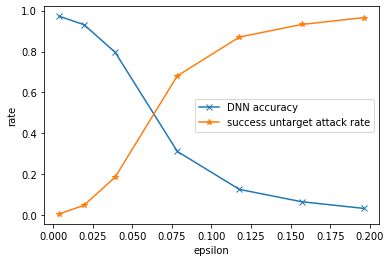

In [16]:
plt.plot(epsilons,acc_untarget,marker='x')
plt.plot(epsilons,success_untarget_attack_rate,marker='*')
plt.xlabel('epsilon')
plt.ylabel('rate')
plt.legend(['DNN accuracy','success untarget attack rate'])

In [17]:
print("Untarget attack")
for i, eps in enumerate(epsilons):
  print("epsilon is:{}, success attack rate is: {}".format(eps, success_untarget_attack_rate[i]))

Untarget attack
epsilon is:0.00392156862745098, success attack rate is: 0.0068437180796731
epsilon is:0.0196078431372549, success attack rate is: 0.04933605720122569
epsilon is:0.0392156862745098, success attack rate is: 0.18702757916241064
epsilon is:0.0784313725490196, success attack rate is: 0.6812053115423902
epsilon is:0.11764705882352941, success attack rate is: 0.8706843718079673
epsilon is:0.1568627450980392, success attack rate is: 0.932073544433095
epsilon is:0.19607843137254902, success attack rate is: 0.9654749744637385


## FGSM based targeted attacks

Intentionally misleading the network to output a specific label designed by the attacker. The formula is shown below
$$
x'\leftarrow clip(x-\epsilon sign(\triangledown \mathcal{l}_{F,y'}(x)))
$$

Here, $\epsilon$ is a small constraint scalar, $\mathcal{l}$ is the loss function

In [18]:
def generate_perturb_target_img(model, X, Y, epsilon):
  y_test_modify = []
  for i in Y:
    y_test_modify.append((i+1)%10)
  x_perturb = []   
  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    pred = model(x_tensor)
    loss = loss_fn(y_test_modify, pred)
  grad = tape.gradient(loss, x_tensor)
  grad_sign = tf.sign(grad)
  x_perturb.append(tf.clip_by_value((x_tensor - epsilon * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [19]:
def generate_perturb_target_correct_img(model, X, Y, epislon):
  y_test_modify = []
  for i in Y:
    y_test_modify.append((i+1)%10)
    
  x_perturb = []
  for i, img in enumerate(X):
    # img = tf.convert_to_tensor(img, dtype=tf.float32)
         
    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(x_tensor)
      pred = model(x_tensor)
      loss = loss_fn(y_test_modify[i], pred)
    grad = tape.gradient(loss, x_tensor)
    grad_sign = tf.sign(grad)
    x_perturb.append(tf.clip_by_value((x_tensor - epislon * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

In [20]:
def cal_Perturb_correct_classify_tar_acc(model, perturbImg, Y):
  count = 0
  pred_label = []
  for i, img in enumerate(perturbImg):
    # img = img[newaxis, ...]
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    pred_label.append(pred)
    
    if pred[0] == (Y[i]+1).numpy():
      
      pred_label.append(pred)
      count+=1
  return count/len(Y), pred_label

In [22]:

acc_target = []
success_target_attack_rate = []


epsilons = [1/255, 5/255, 10/255, 20/255, 30/255, 40/255, 50/255]
numOfCorrectClassifiedTar, correct_classified_tar_img, correct_classified_tar_img_label = correct_classified(DNN, x_test, y_test)
for eps in epsilons:
  x_perturb_tar = generate_perturb_target_img(DNN, x_test, y_test, eps)
  acc_tar, y_pred_tar = cal_Perturb_classify_acc(DNN, x_perturb_tar, y_test)
  acc_target.append(acc_tar[1])
  
  x_perturb_correct_tar_classified = generate_perturb_target_correct_img(DNN, correct_classified_tar_img, correct_classified_tar_img_label, eps)

  acc_perturb_tar_classified, y_correct_tar_pred = cal_Perturb_correct_classify_tar_acc(DNN, x_perturb_correct_tar_classified, correct_classified_tar_img_label)
  success_target_attack_rate.append(acc_perturb_tar_classified)

313/313 - 1s - loss: 0.0727 - accuracy: 0.9779 - 699ms/epoch - 2ms/step
313/313 - 1s - loss: 0.1054 - accuracy: 0.9629 - 643ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2674 - accuracy: 0.9061 - 742ms/epoch - 2ms/step
313/313 - 1s - loss: 1.5922 - accuracy: 0.5661 - 704ms/epoch - 2ms/step
313/313 - 1s - loss: 4.3363 - accuracy: 0.2526 - 702ms/epoch - 2ms/step
313/313 - 1s - loss: 7.4903 - accuracy: 0.1023 - 705ms/epoch - 2ms/step
313/313 - 1s - loss: 10.5930 - accuracy: 0.0413 - 666ms/epoch - 2ms/step


Text(0.5, 1.0, 'target attack')

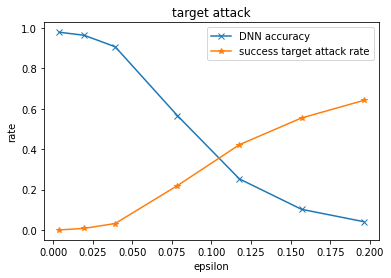

In [23]:
plt.plot(epsilons,acc_target,marker='x')
plt.plot(epsilons,success_target_attack_rate,marker='*')
plt.xlabel('epsilon')
plt.ylabel('rate')
plt.legend(['DNN accuracy','success target attack rate'])
plt.title("target attack")

In [24]:
print("target attack")
for i, eps in enumerate(epsilons):
  print("epsilon is:{}, success attack rate is: {}".format(eps, success_target_attack_rate[i]))

target attack
epsilon is:0.00392156862745098, success attack rate is: 0.00040858018386108274
epsilon is:0.0196078431372549, success attack rate is: 0.008069458631256384
epsilon is:0.0392156862745098, success attack rate is: 0.03207354443309499
epsilon is:0.0784313725490196, success attack rate is: 0.21920326864147088
epsilon is:0.11764705882352941, success attack rate is: 0.4218590398365679
epsilon is:0.1568627450980392, success attack rate is: 0.5540347293156281
epsilon is:0.19607843137254902, success attack rate is: 0.6406537282941778


## Adversarial Retraining against Untargeted FGSM Attacks

For this step, you can assume $\epsilon$ = 10/255 throughout. To defend against adversarial perturbations, the defender adversarially perturbs each image in her training set using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their correct labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the adversarially retrained DNN.

In [25]:
epsilon = 10/255
# x_retraining = x_train
x_perturb_retrain = generate_perturb_untarget_img(DNN, x_train, y_train, epsilon)
y_retrain = np.hstack((y_train, y_train))
x_retrain = []
for re in x_perturb_retrain:
  x_retrain = np.vstack((x_train, re))


In [26]:
print(len(x_retrain))

120000


In [27]:
DNN_retrain = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)                                 
])

In [28]:
DNN_retrain.compile(optimizer='adam', loss=loss_fn,metrics=['accuracy'])

In [29]:
DNN_retrain.fit(x_retrain, y_retrain, epochs=5)

Epoch 1/5
3750/3750 [==============================] - 15s 4ms/step - loss: 0.1340 - accuracy: 0.9612
Epoch 2/5
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0451 - accuracy: 0.9860
Epoch 3/5
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0278 - accuracy: 0.9908
Epoch 4/5
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0216 - accuracy: 0.9929
Epoch 5/5
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0156 - accuracy: 0.9948


In [30]:
res_retrain = DNN_retrain.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0724 - accuracy: 0.9811 - 651ms/epoch - 2ms/step


Get perturb image from DNN_retrain

In [31]:
numOfCorrectClassified, correct_classified_img, correct_classified_img_label = correct_classified(DNN, x_test, y_test)
x_perturb = generate_perturb_untarget_img(DNN_retrain, x_test, y_test, epsilon)
acc_retrain, y_pred_retrain = cal_Perturb_classify_acc(DNN_retrain, x_perturb, y_test)


x_perturb_correct_classified = generate_perturb_untarget_correct_img(DNN_retrain, correct_classified_img, correct_classified_img_label, epsilon)
acc_perturb_classified, y_correct_pred = cal_Perturb_correct_classify_acc(DNN_retrain, x_perturb_correct_classified, correct_classified_img_label)


313/313 - 1s - loss: 7.7030 - accuracy: 0.2213 - 775ms/epoch - 2ms/step


In [32]:
print("The success attack rate is {}".format(1-acc_perturb_classified))

The success attack rate is 0.773953013278856


Get perturb images from baseline DNN

In [33]:
x_perturb_DNN = generate_perturb_untarget_img(DNN, x_test, y_test, epsilon)
acc_retrain1, y_pred_retrain1 = cal_Perturb_classify_acc(DNN_retrain, x_perturb_DNN, y_test)


x_perturb_correct_classified_DNN = generate_perturb_untarget_correct_img(DNN, correct_classified_img, correct_classified_img_label, epsilon)
acc_perturb_classified1, y_correct_pred1 = cal_Perturb_correct_classify_acc(DNN_retrain, x_perturb_correct_classified_DNN, correct_classified_img_label)

313/313 - 1s - loss: 0.0145 - accuracy: 0.9957 - 734ms/epoch - 2ms/step


In [34]:
print("The success attack rate is {}".format(1-acc_perturb_classified1))

The success attack rate is 0.0005107252298263143


We can see that the success atcck rate is high if we use the images that are generated from DNN_retrain. SO, it is not roboust. However, if the images are generated from the baseline DNN, than DNN_retrain works well.

## Challenge

I will implement IFGS here, iterative fast gradient sign methods. It is actually a iterative version of FGS. IFGS will perturb each pixel with a small amount for multiple times. For non-targeted attacks, the formula will be
$$
x_0'=x,x_{N+1}'\leftarrow clip_{\epsilon}(x_N'+\alpha sign(\triangledown \mathcal{l}_{F,y^*}(x)))
$$

IFGS methods are capable of generating adversarial inputs with smaller distortion when compared to basic FGS methods.

In [35]:
fashionMnist = tf.keras.datasets.fashion_mnist

(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashionMnist.load_data()
x_train_fashion, x_test_fashion = x_train_fashion / 255.0, x_test_fashion / 255.0

4431872/4422102 [==============================] - 0s 0us/step


In [36]:
print(x_train_fashion.shape)
print(x_test_fashion.shape)

(60000, 28, 28)
(10000, 28, 28)


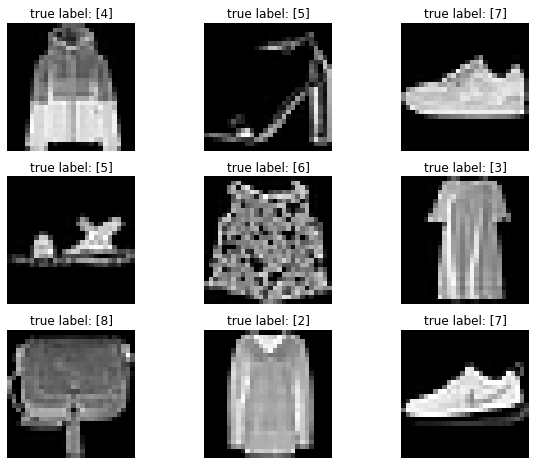

In [37]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_train_fashion.shape[0], size=1)
  img, label = (x_train_fashion[index], y_train_fashion[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [38]:
DNN_fashion = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)                                 
])

In [39]:
DNN_fashion.compile(optimizer='adam', loss=loss_fn,metrics=['accuracy'])
DNN_fashion.fit(x_train_fashion, y_train_fashion, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4819 - accuracy: 0.8282
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3657 - accuracy: 0.8661
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3261 - accuracy: 0.8794
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3014 - accuracy: 0.8885
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2835 - accuracy: 0.8952


In [40]:
res = DNN_fashion.evaluate(x_test_fashion,  y_test_fashion, verbose=2)

313/313 - 1s - loss: 0.3515 - accuracy: 0.8709 - 658ms/epoch - 2ms/step


In [42]:
def generate_perturb_untarget_im_iter(iteration, model, X, Y, epislon):
  # X = tf.convert_to_tensor(X, dtype=tf.float32)
  x_perturb = [] 
  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  for i in range(iteration):
    
    with tf.GradientTape() as tape:
      tape.watch(x_tensor)
      pred = model(x_tensor)
      loss = loss_fn(Y, pred)
    grad = tape.gradient(loss, x_tensor)
    grad_sign = tf.sign(grad)
    x_tensor = tf.clip_by_value((x_tensor + epislon * grad_sign), clip_value_min = 0, clip_value_max = 1)
  x_perturb.append(x_tensor)
  return x_perturb

In [43]:
def calRMSE(adv_img, ori_img):
  RMSE = []
  for i, img in enumerate(adv_img):
    rmse = np.sqrt(np.sum((img-ori_img[i])**2)/(28*28))
    
    RMSE.append(rmse)
    
  return np.sum(RMSE)/len(RMSE)

In [44]:
x_perturb_fashion = generate_perturb_untarget_im_iter(5, DNN_fashion, x_test_fashion, y_test_fashion, 1/255)

In [45]:
RMSE = calRMSE(x_perturb_fashion[0], x_test_fashion)

In [47]:
print("The RMSE of original images and perturb images is {}".format(RMSE))

The RMSE of original images and perturb images is 0.016751163356010457


The RMSE is less than 5/255 = 0.0196. So, we will do 5 iterations and when epsilon = 1/255.

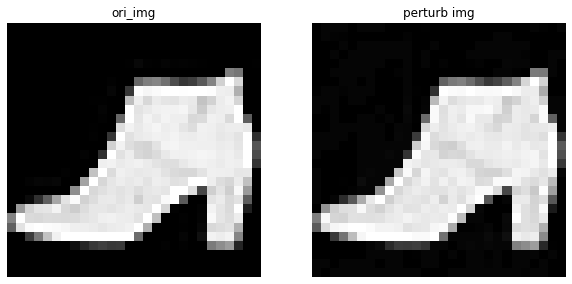

In [48]:
figure = plt.figure(figsize=(10,8))
index = np.random.randint(x_test_fashion.shape[0], size=1)
img1, label1 = (x_test_fashion[index], y_test_fashion[index])
figure.add_subplot(1, 2, 1)
plt.title("ori_img")
plt.axis("off")
plt.imshow(img1.squeeze(), cmap="gray")
img2, label2 = (np.array(x_perturb_fashion[0][index[0]]), y_test_fashion[index])
figure.add_subplot(1, 2, 2)
plt.title("perturb img")
plt.axis("off")
plt.imshow(img2.squeeze(), cmap="gray")
plt.show()